In [4]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
# Req for package
sys.path.append("../")
from src.Dataset.Utils import getDataset, getSplit
from src.NN.Utils import train, test, DEVICE

torch.backends.cudnn.benchmark = True

In [5]:
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Model

In [114]:
# Up samples to 256 from 128
class Up(nn.Module):
    def __init__(self):
        super(Up, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d7 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        x = self.pool3(torch.relu(self.d3(self.bn3(self.conv3(x)))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d7(x)
        
        
        x = self.fc4(x)
        return x

In [119]:
# Up samples to 256 from 128
class UpMinus(nn.Module):
    def __init__(self):
        super(UpMinus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(7680, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d7 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d7(x)
        
        
        x = self.fc4(x)
        return x

In [120]:
# Up samples to 256 from 128
class UpPlus(nn.Module):
    def __init__(self):
        super(UpPlus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        self.d4 = nn.Dropout(0.2)
        
        """self.conv4 = nn.Conv1d(512, 1500, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1500)
        self.d5 = nn.Dropout(0.5)"""
        
        
        self.fc1 = nn.Linear(7168, 512)
        self.d6 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d7 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d8 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d2(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d3(self.conv2(x)))))
        x = self.pool3(torch.relu(self.bn3(self.d4(self.conv3(x)))))
        
        x = self.pool4(torch.relu(self.bn4(self.d4(self.conv4(x)))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d7(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d8(x)
        
        
        x = self.fc4(x)
        return x

In [21]:
# Up samples to 256 from 128
# Up samples to 256 from 128
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        
        x = x.reshape(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = self.d1(self.fc3(x))
        x = self.fc4(x)
        
        x = x.view(batch_size, 6)
        return x

# Training

In [10]:
dataset, scaler = getDataset()

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:45<00:00, 48.86it/s]


In [11]:
train_loader, test_loader = getSplit(dataset)

In [126]:
up = Up()

In [ ]:
up_losses, up_val_losses, = train(train_loader, up, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 68/550: 100%|██████████████████████████████████| 56/56 [00:02<00:00, 26.01batch/s, lastLoss=0.135, valLoss=0.196]


Epoch 136/550: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 24.80batch/s, lastLoss=0.125, valLoss=0.176]


Epoch 189/550:  21%|███████▎                          | 12/56 [00:00<00:01, 25.72batch/s, lastLoss=0.12, valLoss=0.156]

In [ ]:
upMinus = UpMinus()

In [ ]:
up2_losses, up2_val_losses, = train(train_loader, up2, val_loader=test_loader, LR=0.0001, epochs=550)

In [ ]:
upPlus = UpPlus()

In [ ]:
upPlus_losses, upPlus_val_losses, = train(train_loader, upPlus, val_loader=test_loader, LR=0.0001, epochs=550)

In [46]:
rnn = RNN()

In [47]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 68/550: 100%|█████████████████████████████████| 56/56 [00:04<00:00, 12.24batch/s, lastLoss=0.109, valLoss=0.0902]


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.13batch/s, lastLoss=0.0918, valLoss=0.0703]


Epoch 204/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.19batch/s, lastLoss=0.0842, valLoss=0.0645]


Epoch 272/550: 100%|█████████████████████████████████| 56/56 [00:04<00:00, 12.29batch/s, lastLoss=0.08, valLoss=0.0664]


Epoch 340/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.17batch/s, lastLoss=0.0737, valLoss=0.0584]


Epoch 408/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.19batch/s, lastLoss=0.0719, valLoss=0.0539]


Epoch 476/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.33batch/s, lastLoss=0.0705, valLoss=0.0543]


Epoch 544/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.26batch/s, lastLoss=0.0644, valLoss=0.0511]


Epoch 550/550: 100%|███████████████████████████████| 56/56 [00:04<00:00, 12.29batch/s, lastLoss=0.0653, valLoss=0.0491]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.07337738 0.11302458 0.08105624 0.10696117 0.0588244  0.07834882]
Average overall loss: 4.758115804579305e-05


In [90]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(names, train_loss, val_loss, epochs=550):
    if len(names)%2 == 0:
        rs = len(names)//2
        cs = len(names)//2
    else:
        rs, cs = len(names), 1
        
    fig, ax = plt.subplots(
        rs, cs, figsize=(35 if len(names) != 1 else 10, len(names)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    if cs == 1 and rs == 1:
        ax.set_title(names[0], fontsize=40)
        ax.xaxis.set_tick_params(labelsize=35)
        ax.yaxis.set_tick_params(labelsize=35)
        for j in range(2):
            ax.plot(x, tv_loss[0][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    elif cs == 1:
        for i in range(len(names)):
            ax[i].set_title(names[i], fontsize=40)
            ax[i].xaxis.set_tick_params(labelsize=35)
            ax[i].yaxis.set_tick_params(labelsize=35)
            for j in range(2):
                ax[i].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    else:
        pos = 0
        for i in range(rs):
            for j in range(cs):
                ax[i][j].set_title(names[pos], fontsize=40)
                ax[i][j].xaxis.set_tick_params(labelsize=35)
                ax[i][j].yaxis.set_tick_params(labelsize=35)
                for k in range(2):
                    ax[i][j].plot(x, tv_loss[pos][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
                pos += 1
    
    """ for i in range(len(tv_loss)):
        for j in range(2):
            print(i//2)
            print(0 if i < len(models)//2 else 1, i//len(models)//2)
            ax[0 if i < len(models)//2 else 1][i//len(models)//2].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")"""
    
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend()
    plt.show()

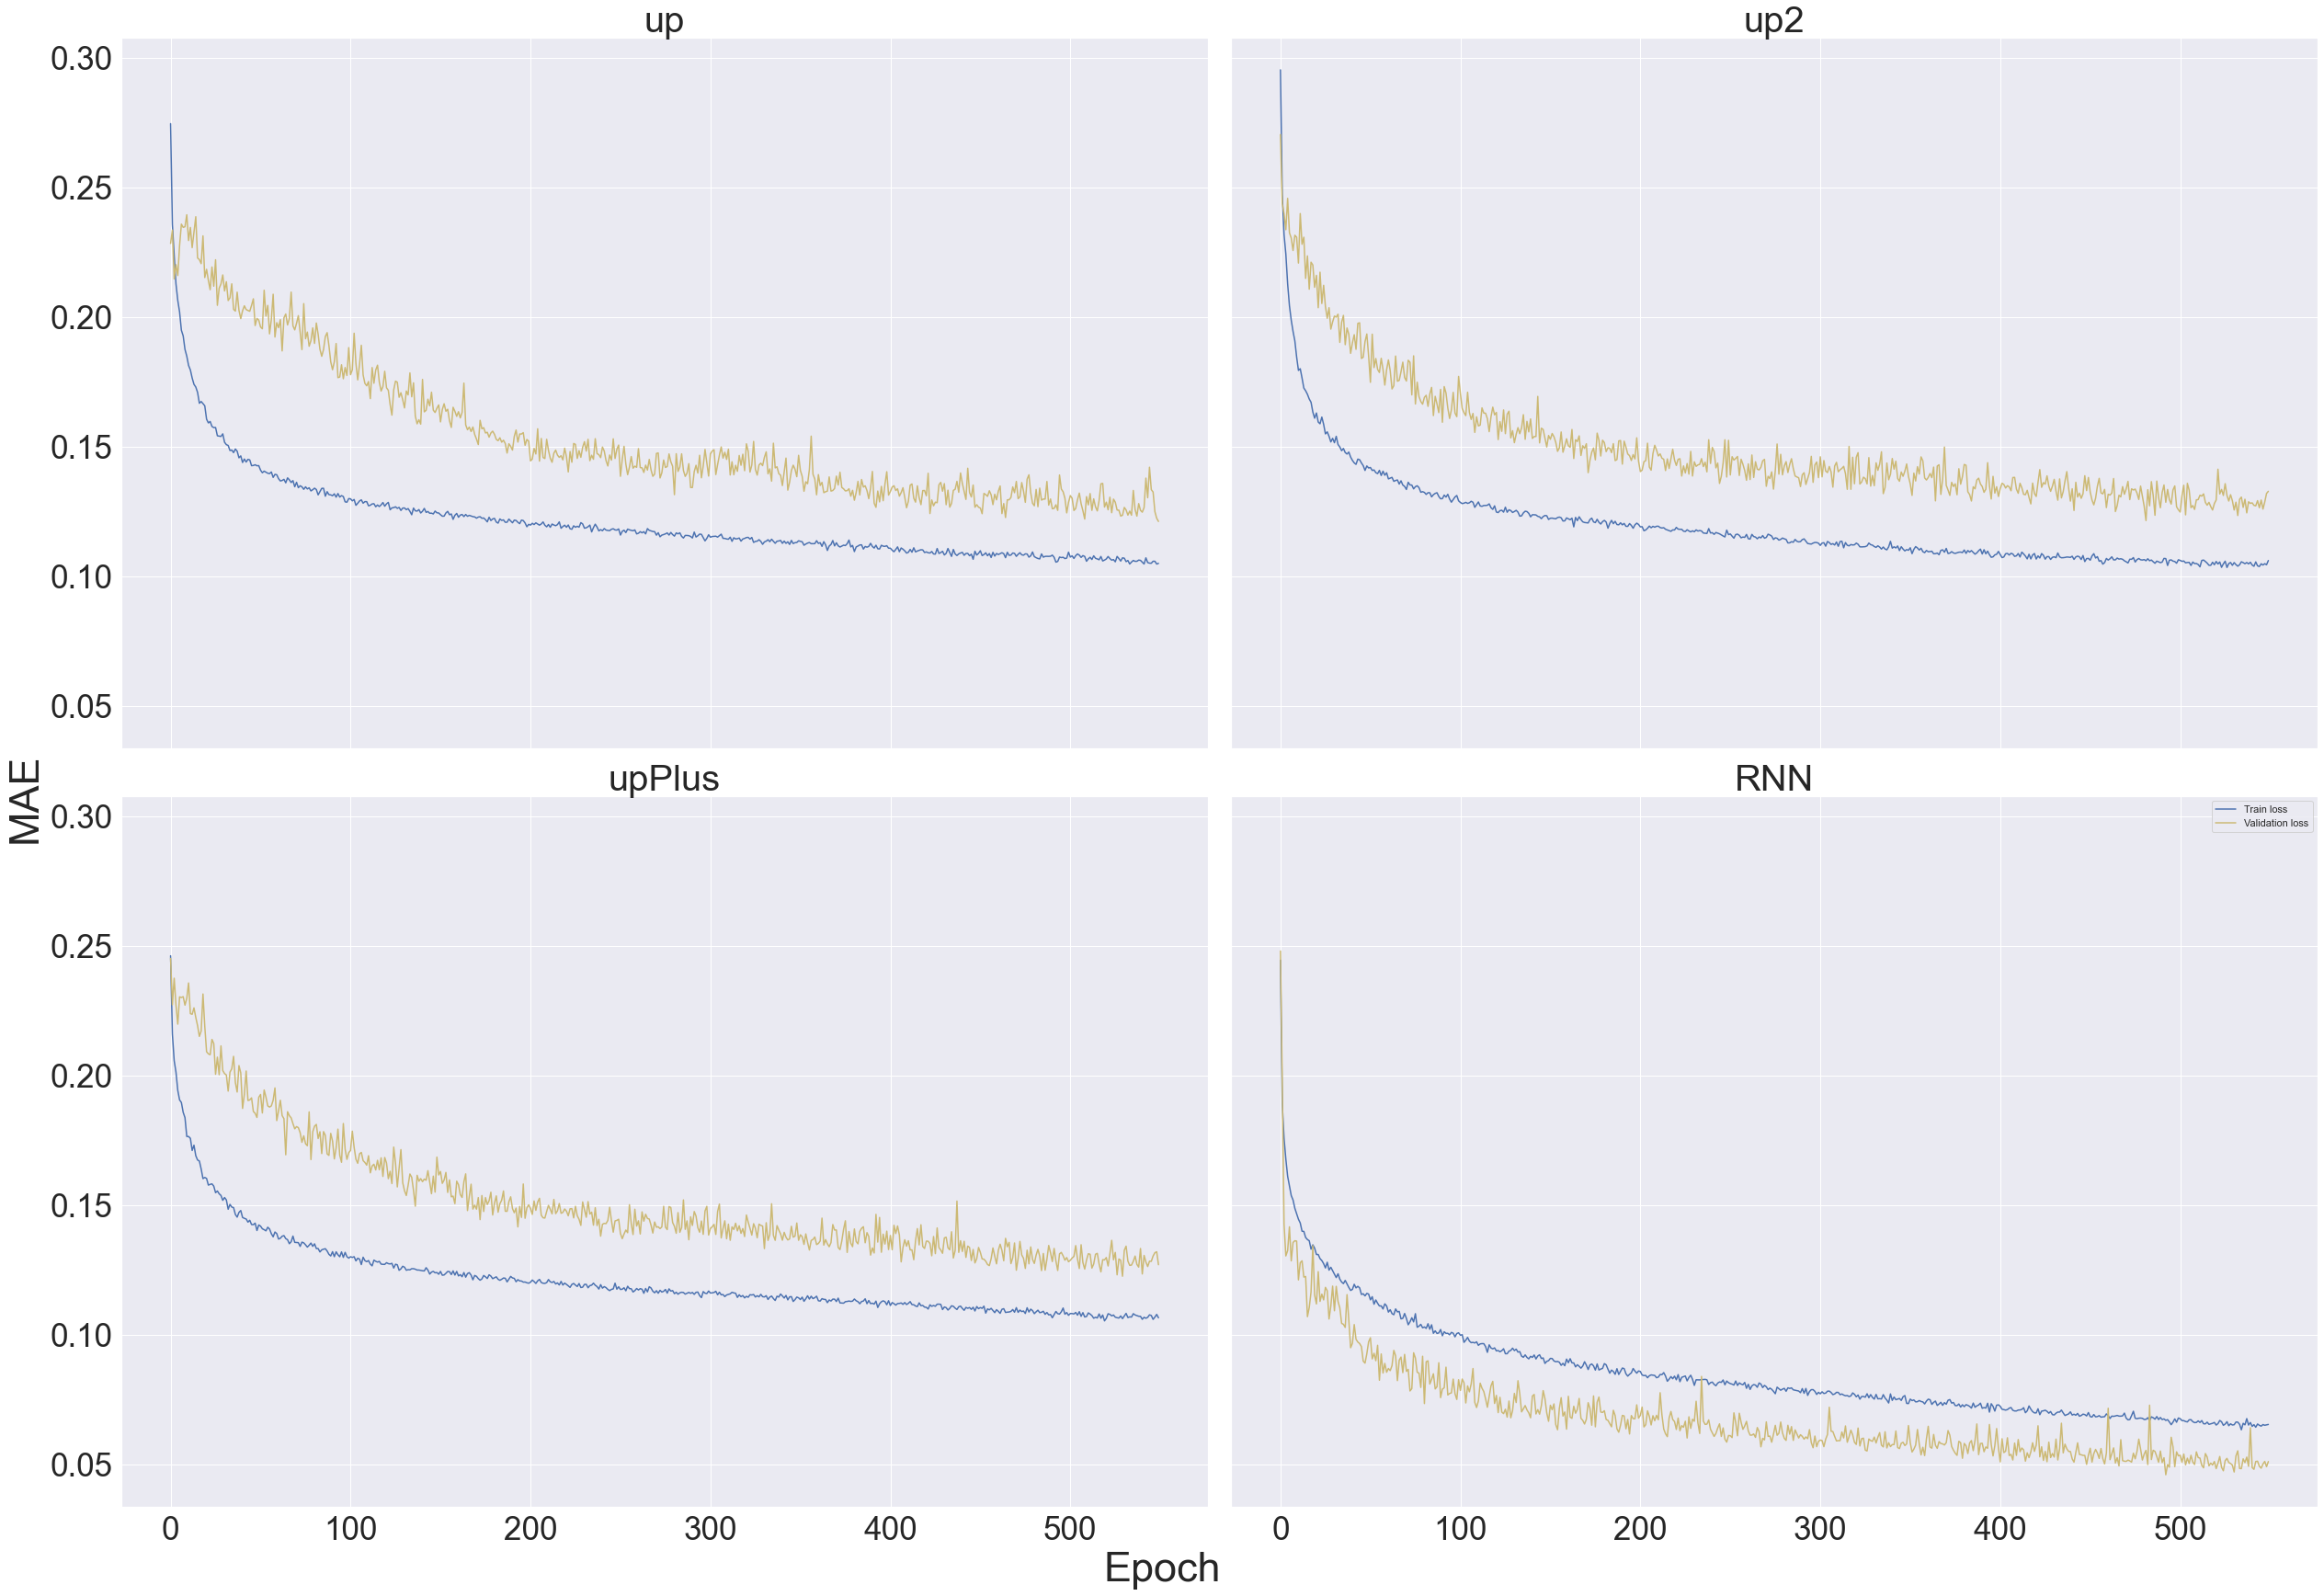

In [85]:
up2_losses, _, up2_val_losses,
printCurves(["up", "up2", "upPlus", "RNN"], [up_losses, up2_losses, upPlus_losses, rnn_losses], [up_val_losses, up2_val_losses, upPlus_val_losses, rnn_val_losses])

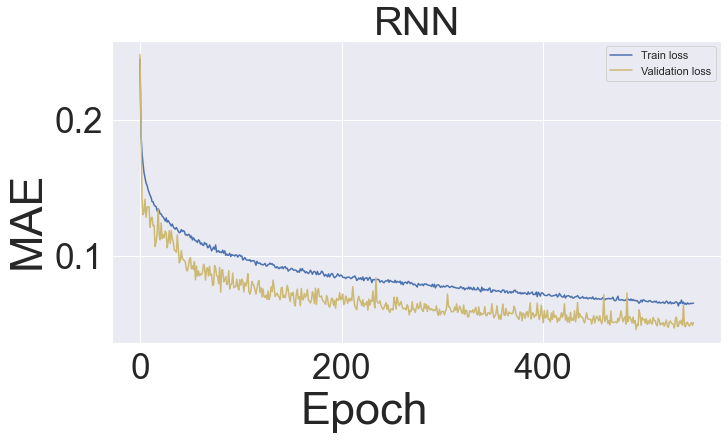

In [91]:
up2_losses, _, up2_val_losses,
printCurves(["RNN"], [rnn_losses], [rnn_val_losses])

In [53]:
print(up_val_losses[-6:])
print(up2_val_losses[-6:])
print(upPlus_val_losses[-6:])
print(rnn_val_losses[-6:])

[0.14209652791420618, 0.133433232208093, 0.13253662288188933, 0.12497668514649073, 0.12242856721083323, 0.12118584911028545]
[0.12648351987202963, 0.12943871766328813, 0.12594904750585556, 0.1286994258562724, 0.13198802371819815, 0.13281246274709702]
[0.12836328893899918, 0.12830707828203838, 0.13036616990963618, 0.13163498938083648, 0.13200120627880096, 0.1270050490895907]
[0.04930006638169289, 0.048537828773260114, 0.050133579224348065, 0.05114713807900747, 0.04912982707222303, 0.05109744469324748]


In [63]:
print(up_val_losses[-6:])
print(up2_val_losses[-6:])
print(upPlus_val_losses[-6:])

[0.1048719455798467, 0.1569494863351186, 0.10044145534435908, 0.07857046475013098, 0.12099731812874476, 0.11672636568546295]
[0.07500391776363055, 0.08036220024029414, 0.14769022266070048, 0.07771025945742925, 0.12791383564472197, 0.07599554061889649]
[0.08352651000022888, 0.14896512230237324, 0.11090785612662633, 0.10950678586959839, 0.09152971704800923, 0.12785176038742066]


In [99]:
test(test_loader, up, scaler=scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.68 batch/s]


(array([56.15565181, 99.89455342, 91.47125334, 85.56780219, 96.2455634 ,
        94.7470665 ]),
 87.76824002464612,
 array([92.38691 , 57.116554, 99.70223 , 99.362076, 34.77557 , 61.062267],
       dtype=float32))

In [104]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-loss as a percentage of the original value
"""
def getParameterLoss(models, names, test_loader=test_loader, mspe_based=True):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        ps, avg, _ = test(test_loader, model, scaler=scaler)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE').set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df
    
"""printVals = lambda x: print(''.join(
    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    """

"printVals = lambda x: print(''.join(\n    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    "

In [105]:
df = getParameterLoss([up, up2, upPlus, rnn],["up", "up2", "Up (+1 block)", "RNN"])

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.15 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
up,99.852617,88.501197,95.900027,83.468455,89.150478,79.666328,87.902328
up2,91.142978,83.776711,93.435057,92.784911,88.334456,95.190711,86.594496
upPlus,70.910576,94.738501,84.275725,89.324391,98.890482,70.568532,87.072966
RNN,98.454550,99.627703,98.328306,98.124951,98.200331,92.247677,95.073922


(60.0, 100.0)

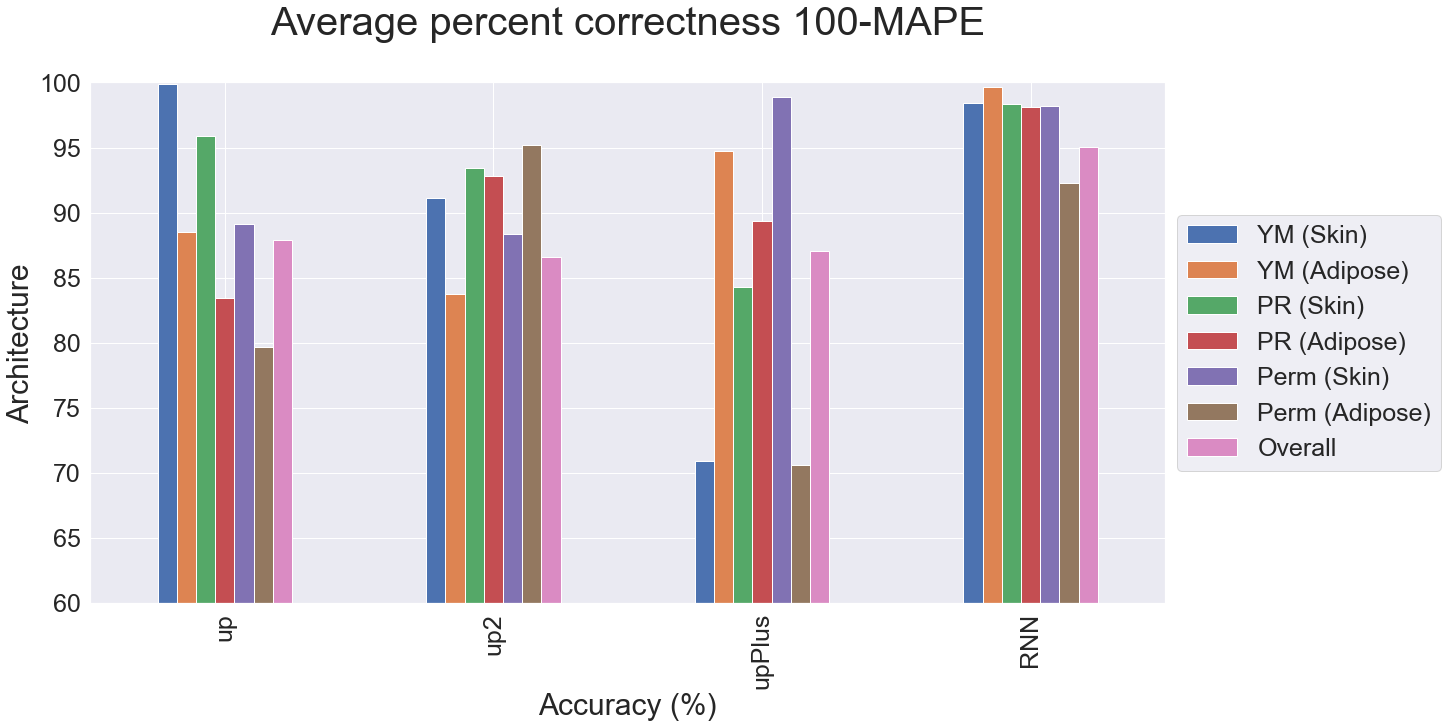

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
ax.set_ylim(60, 100)
#fig.savefig("../Results/testArchitecturesbarmspe.svg", bbox_inches='tight')